## Visualizing the results using tables and plots

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nvda_data1_df = pd.read_csv("NVDA_outputData1.csv")
spy_data1_df = pd.read_csv("SPY_outputData1.csv")
vix_data1_df = pd.read_csv("^VIX_outputData1.csv")

In [3]:
df= pd.read_csv("options_data1.csv")
nvda_data1_spot = df.query('ticker == "NVDA"').iloc[1,-2]
spy_data1_spot = df.query('ticker == "SPY"').iloc[1,-2]

In [23]:
nvda_data1_spot
spy_data1_spot

603.619995

In [27]:
nvda_strikes = nvda_data1_df["Strike"].values
# Find index of the closest strike
closest_index = np.argmin(np.abs(nvda_strikes - nvda_data1_spot))

# Get the closest strike using the index
closest_strike = nvda_strikes[closest_index]

In [56]:
# Ensure Expiration is in datetime format
nvda_data1_df["Expiration"] = pd.to_datetime(nvda_data1_df["Expiration"])
spy_data1_df["Expiration"] = pd.to_datetime(spy_data1_df["Expiration"])

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "NewtonIV", "ImpliedVolatility"]

# Function to get ATM IV for each expiration
def get_atm_iv(df, spot_price):
    if df.empty:
        return None  # Return None if no matching expiration
    
    # Find ATM strike (closest to spot price)
    closest_strike = df.iloc[(df["Strike"] - spot_price).abs().argmin()]["Strike"]
    
    # Filter the row that matches the closest strike
    atm_row = df[df["Strike"] == closest_strike]
    
    
    return atm_row

# Apply the function to groupby object for each expiration
nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=nvda_data1_spot).reset_index(drop=True)
spy_atm_iv = spy_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=spy_data1_spot).reset_index(drop=True)

# Combine both NVDA and SPY data into a single table
atm_iv_table = pd.concat([nvda_atm_iv, spy_atm_iv], ignore_index=True)
atm_iv_table = atm_iv_table[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/1561196927.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=nvda_data1_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/1561196927.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atm_iv = spy_data1_df.groupby

In [57]:
atm_iv_table

,Ticker,Expiration,OptionType,Strike,BisectionIV,NewtonIV,ImpliedVolatility
0,NVDA,2025-02-21,Call,132.0,0.458217,0.458217,0.419684
1,NVDA,2025-02-21,Put,132.0,0.511800,0.511800,0.453130
2,NVDA,2025-03-21,Call,132.0,0.586375,0.586375,0.585942
3,NVDA,2025-03-21,Put,132.0,0.611904,0.611904,0.578007
4,NVDA,2025-04-17,Call,130.0,0.532450,0.532450,0.545293
5,NVDA,2025-04-17,Put,130.0,0.548353,0.548353,0.517461
6,SPY,2025-02-21,Call,604.0,0.107713,0.107713,0.103250
7,SPY,2025-02-21,Put,604.0,0.152178,0.152177,0.129647
8,SPY,2025-03-21,Call,604.0,0.120918,0.120918,0.134149
9,SPY,2025-03-21,Put,604.0,0.148769,0.148769,0.129083


In [55]:
desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "NewtonIV", "ImpliedVolatility"]

nvda_average_iv_table = nvda_data1_df.groupby(["Expiration", "OptionType", "InTheMoney"])[["BisectionIV", "ImpliedVolatility"]].mean().reset_index()
spy_average_iv_table = spy_data1_df.groupby(["Expiration", "OptionType", "InTheMoney"])[["BisectionIV", "ImpliedVolatility"]].mean()

#concat these tables
nvda_average_iv_table

,Expiration,OptionType,InTheMoney,BisectionIV,ImpliedVolatility
0,2025-02-21,Call,False,0.275367,4.213820
1,2025-02-21,Call,True,0.047756,0.219976
2,2025-02-21,Put,False,1.123846,1.788257
3,2025-02-21,Put,True,0.295309,0.475116
4,2025-03-21,Call,False,0.249491,2.737434
5,2025-03-21,Call,True,0.180797,1.006442
6,2025-03-21,Put,False,0.954504,0.942719
7,2025-03-21,Put,True,0.409862,0.369171
8,2025-04-17,Call,False,0.575801,0.576083
9,2025-04-17,Call,True,0.247414,1.064953


In [53]:
# Define a function to compute the average IV for a given DataFrame
def compute_average_iv(df, ticker):
    avg_iv_table = (
        df.groupby(["Expiration", "OptionType", "InTheMoney"])[["BisectionIV", "ImpliedVolatility"]]
        .mean()
        .reset_index()
    )
    avg_iv_table["Ticker"] = ticker  # Add a column to distinguish NVDA vs SPY
    return avg_iv_table

# Compute average IV tables for NVDA and SPY
nvda_average_iv_table = compute_average_iv(nvda_data1_df, "NVDA")
spy_average_iv_table = compute_average_iv(spy_data1_df, "SPY")

# Concatenate the tables
combined_average_iv_table = pd.concat([nvda_average_iv_table, spy_average_iv_table], ignore_index=True)

# Reorder columns to match the ATM IV table format
desired_columns = ["Ticker", "Expiration", "OptionType", "InTheMoney", "BisectionIV", "ImpliedVolatility"]
combined_average_iv_table = combined_average_iv_table[desired_columns]

In [54]:
combined_average_iv_table

,Ticker,Expiration,OptionType,InTheMoney,BisectionIV,ImpliedVolatility
0,NVDA,2025-02-21,Call,False,0.275367,4.213820
1,NVDA,2025-02-21,Call,True,0.047756,0.219976
2,NVDA,2025-02-21,Put,False,1.123846,1.788257
3,NVDA,2025-02-21,Put,True,0.295309,0.475116
4,NVDA,2025-03-21,Call,False,0.249491,2.737434
5,NVDA,2025-03-21,Call,True,0.180797,1.006442
6,NVDA,2025-03-21,Put,False,0.954504,0.942719
7,NVDA,2025-03-21,Put,True,0.409862,0.369171
8,NVDA,2025-04-17,Call,False,0.575801,0.576083
9,NVDA,2025-04-17,Call,True,0.247414,1.064953


In [67]:
# VIX table
# get VIX spot and its ATM options
vix_data1_spot = df[df["ticker"] == "^VIX"].iloc[0,-2]

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "NewtonIV", "ImpliedVolatility"]
vix_atm_iv = vix_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=vix_data1_spot).reset_index(drop=True)

vix_atm_iv = vix_atm_iv[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/2482536726.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vix_atm_iv = vix_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=vix_data1_spot).reset_index(drop=True)


In [68]:
vix_data1_spot

15.9

In [69]:
vix_atm_iv

,Ticker,Expiration,OptionType,Strike,BisectionIV,NewtonIV,ImpliedVolatility
0,^VIX,2025-02-19,Call,16.0,1.632540,1.632540,1.419920
1,^VIX,2025-02-19,Put,16.0,0.242041,0.242040,0.218758
2,^VIX,2025-03-18,Call,16.0,1.261380,1.261380,1.238290
3,^VIX,2025-03-18,Put,16.0,0.382678,0.382679,0.365241
4,^VIX,2025-04-16,Call,16.0,1.185660,1.185660,1.184570
5,^VIX,2025-04-16,Put,16.0,0.374354,0.374354,0.352546


In [71]:
nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=nvda_data1_spot).reset_index(drop=True)
spy_atm_iv = spy_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=spy_data1_spot).reset_index(drop=True)
vix_atm_iv = vix_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=vix_data1_spot).reset_index(drop=True)

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "Bid", "Ask", "Parity_price"]


# Combine both NVDA and SPY data into a single table
atm_iv_table = pd.concat([nvda_atm_iv, spy_atm_iv, vix_atm_iv], ignore_index=True)
atm_iv_table = atm_iv_table[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/4280825565.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_iv, spot_price=nvda_data1_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_65128/4280825565.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atm_iv = spy_data1_df.groupby("

In [72]:
atm_iv_table

,Ticker,Expiration,OptionType,Strike,Bid,Ask,Parity_price
0,NVDA,2025-02-21 00:00:00,Call,132.0,3.45,3.50,3.886720
1,NVDA,2025-02-21 00:00:00,Put,132.0,4.05,4.10,3.683280
2,NVDA,2025-03-21 00:00:00,Call,132.0,9.75,9.80,10.294000
3,NVDA,2025-03-21 00:00:00,Put,132.0,9.90,10.00,9.576040
4,NVDA,2025-04-17 00:00:00,Call,130.0,12.80,12.90,13.340100
5,NVDA,2025-04-17 00:00:00,Put,130.0,10.50,10.60,10.189900
6,SPY,2025-02-21 00:00:00,Call,604.0,3.92,3.94,5.509720
7,SPY,2025-02-21 00:00:00,Put,604.0,5.32,5.35,3.740280
8,SPY,2025-03-21 00:00:00,Call,604.0,10.22,10.25,12.324700
9,SPY,2025-03-21 00:00:00,Put,604.0,10.18,10.21,8.125340


## Plot for implied volatility

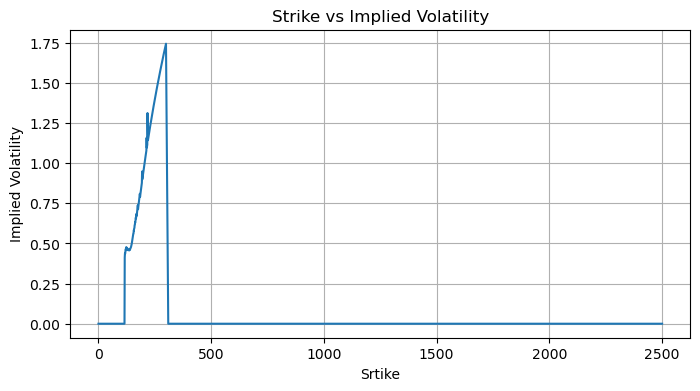

In [96]:
# NVDA call
expirations = nvda_data1_df["Expiration"].unique()

nvda_call_df = nvda_data1_df[nvda_data1_df["OptionType"] == "Call"]
nvda_call_df = nvda_call_df.loc[nvda_call_df["Expiration"] == expirations[0]]

plt.figure(figsize=(8, 4))
plt.plot(nvda_call_df["Strike"], nvda_call_df["BisectionIV"])

# Labels and Title
plt.xlabel("Srtike")
plt.ylabel("Implied Volatility")
plt.title("Strike vs Implied Volatility")
plt.grid(True)  # Add grid lines

# Show the plot
plt.show()

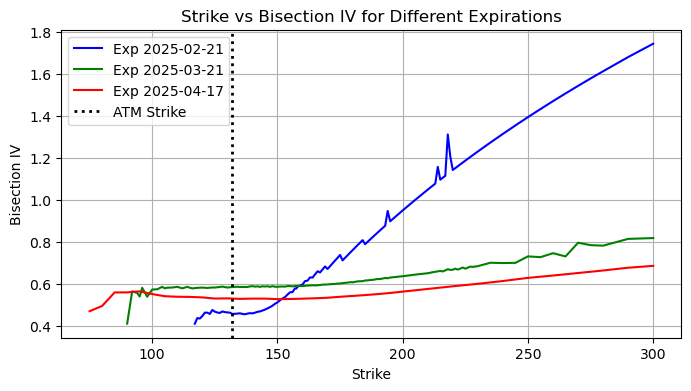

In [ ]:
# Filter Calls first
nvda_call_df = nvda_data1_df.loc[nvda_data1_df["OptionType"] == "Call"]

# Filter for each expiration & valid BisectionIV values
nvda_call_df1 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[0]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df2 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[1]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df3 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[2]) & (nvda_call_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_call_df1["Strike"], nvda_call_df1["BisectionIV"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_call_df2["Strike"], nvda_call_df2["BisectionIV"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_call_df3["Strike"], nvda_call_df3["BisectionIV"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Bisection IV")
plt.title("Strike vs Bisection IV for Different Expirations")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()


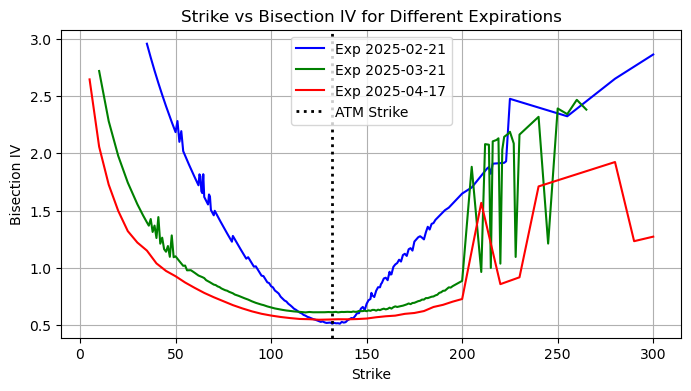

In [97]:
# Filter Puts first
nvda_put_df = nvda_data1_df.loc[nvda_data1_df["OptionType"] == "Put"]

# Filter for each expiration & valid BisectionIV values
nvda_put_df1 = nvda_put_df.loc[(nvda_put_df["Expiration"] == expirations[0]) & (nvda_put_df["BisectionIV"] > 0.0001)]
nvda_put_df2 = nvda_put_df.loc[(nvda_put_df["Expiration"] == expirations[1]) & (nvda_put_df["BisectionIV"] > 0.0001)]
nvda_put_df3 = nvda_put_df.loc[(nvda_put_df["Expiration"] == expirations[2]) & (nvda_put_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_put_df1["Strike"], nvda_put_df1["BisectionIV"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_put_df2["Strike"], nvda_put_df2["BisectionIV"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_put_df3["Strike"], nvda_put_df3["BisectionIV"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Bisection IV")
plt.title("Strike vs Bisection IV for Different Expirations")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()
